In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import glob, warnings, itertools
%matplotlib inline


In [2]:
path = r'C:\\Users\\jpisel\\Downloads\\pickups\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0], parse_dates=[0], header=None)
    listed.append(df)
frame = pd.concat(listed)



In [3]:
frame.columns=['company']
frame['counts']=1

In [4]:
frame['lyft']=frame['company']=='Lyft'
frame['uber']=frame['company']=='Uber'
lyfted=frame.query('lyft == True ')
ubered=frame.query('uber == True')

In [5]:
ubered.head()

,company,counts,lyft,uber
0,,,,
2016-08-01 00:00:06,Uber,1,False,True
2016-08-01 00:00:17,Uber,1,False,True
2016-08-01 00:00:21,Uber,1,False,True
2016-08-01 00:00:34,Uber,1,False,True
2016-08-01 00:01:22,Uber,1,False,True


In [11]:
new=frame.resample('d').sum()
new.head()

,counts,lyft,uber
0,,,
2016-06-13,101,0.0,101.0
2016-06-14,134,0.0,134.0
2016-06-15,133,0.0,133.0
2016-06-16,140,0.0,140.0
2016-06-17,177,24.0,153.0


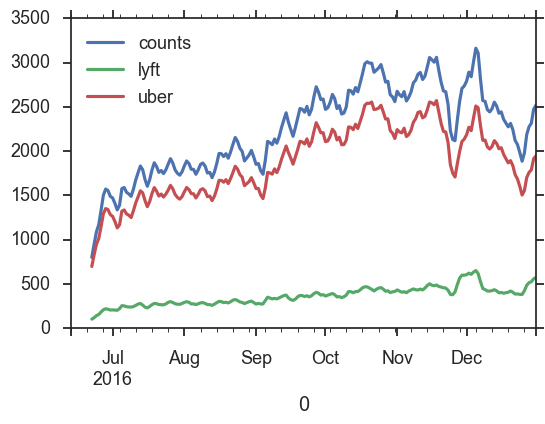

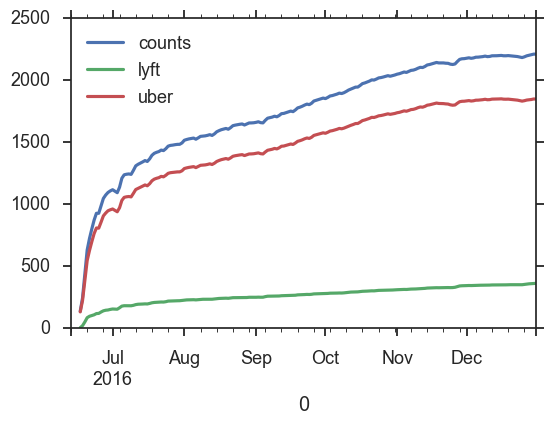

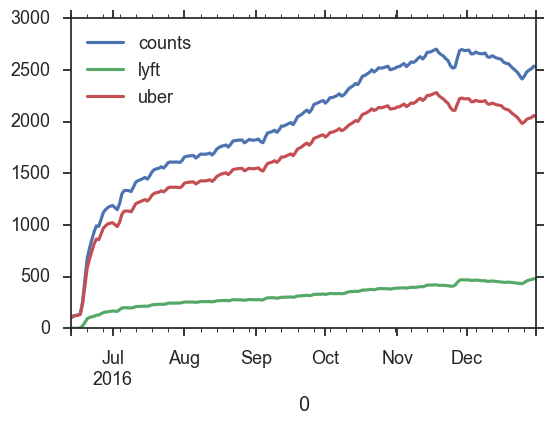

In [12]:
new.rolling(10).mean().plot(label='rolling')
new.expanding(5).mean().plot(label='expanding')
new.ewm(alpha=0.03).mean().plot(label='emwa')

In [13]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [62]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new['counts'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:3409.3186290047624
ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:2909.236593959634
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:3123.9761158108254
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:3032.3738624716443
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:2938.1261853750666
ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:2906.661530530394
ARIMA(0, 0, 1)x(0, 0, 0, 7)12 - AIC:3455.1194473785963
ARIMA(0, 0, 1)x(0, 0, 1, 7)12 - AIC:3212.7457820742893
ARIMA(0, 0, 1)x(0, 1, 0, 7)12 - AIC:2984.045907158083
ARIMA(0, 0, 1)x(0, 1, 1, 7)12 - AIC:2798.8090444206414
ARIMA(0, 0, 1)x(1, 0, 0, 7)12 - AIC:3020.2464103932843
ARIMA(0, 0, 1)x(1, 0, 1, 7)12 - AIC:2913.2075493186157
ARIMA(0, 0, 1)x(1, 1, 0, 7)12 - AIC:2851.170369832904
ARIMA(0, 0, 1)x(1, 1, 1, 7)12 - AIC:2798.226518243785
ARIMA(0, 1, 0)x(0, 0, 1, 7)12 - AIC:3050.0474437050075
ARIMA(0, 1, 0)x(0, 1, 1, 7)12 - AIC:2830.419548033303
ARIMA(0, 1, 0)x(1, 0, 0, 7)12 - AIC:3015.404303214701
ARIMA(0, 1, 0)x(1, 0, 1, 7)12 - AIC:2942.250471715409
ARIMA(0, 1, 0)x(1,

In [65]:
mod = sm.tsa.statespace.SARIMAX(new['counts'], order=(1,0,1), seasonal_order=(0,1,1,7), 
                                enforce_stationarity=False, enforce_invertibility=False)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3913      0.074      5.286      0.000       0.246       0.536
ma.L1          0.4394      0.069      6.367      0.000       0.304       0.575
ma.S.L7       -0.7056      0.063    -11.278      0.000      -0.828      -0.583
sigma2      1.775e+05   1.18e+04     15.006      0.000    1.54e+05    2.01e+05


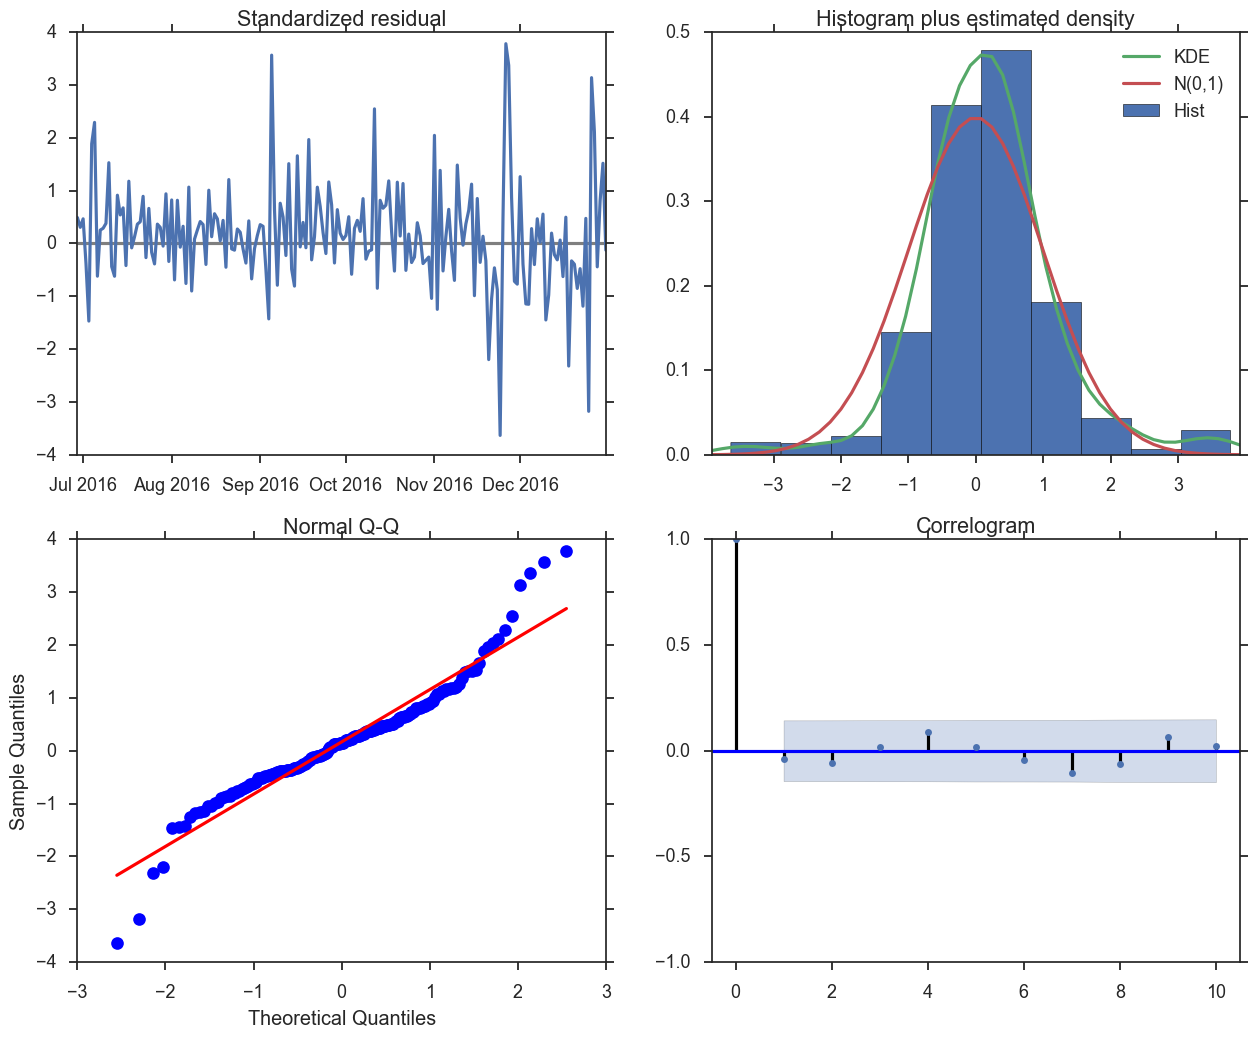

In [66]:
results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [20]:
forecast_start='2016-11-01'
forecast_end='2016-12-31'
pred = results.get_prediction(start=forecast_start)
pred_ci = pred.conf_int()

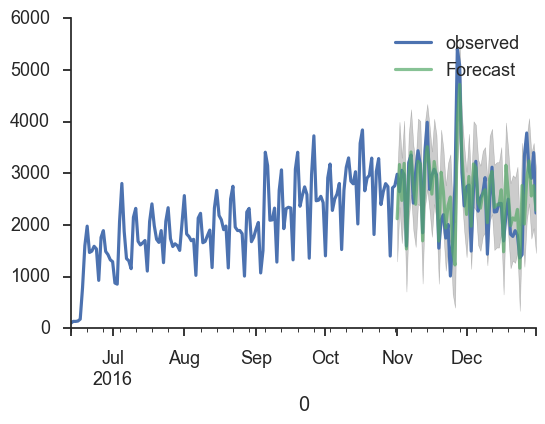

In [21]:
ax = new['counts'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

In [67]:
from sklearn import metrics
y_forecasted=pred.predicted_mean[forecast_start:forecast_end]
y_truth=new['counts'][forecast_start:forecast_end]
#Compute mean absolute error
metrics.mean_absolute_error(y_truth,y_forecasted)

408.76917338674957

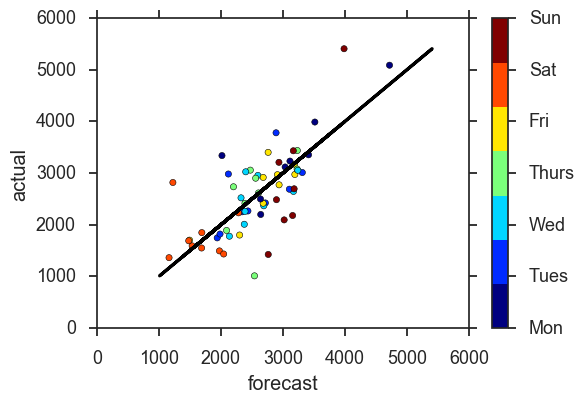

In [24]:
dayofweek = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweek, cmap=plt.cm.get_cmap('jet', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

In [68]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendars = USFederalHolidayCalendar()
holidays = calendars.holidays('2016', '2017', return_name=True)

allUSholidays = pd.concat([holidays,
                         "before " + holidays.shift(-1, 'D'),
                         "after " + holidays.shift(1, 'D')])
allUSholidays = allUSholidays.sort_index()
allUSholidays.tail()

2016-11-24          Thanksgiving
2016-11-25    after Thanksgiving
2016-12-25      before Christmas
2016-12-26             Christmas
2016-12-27       after Christmas
dtype: object

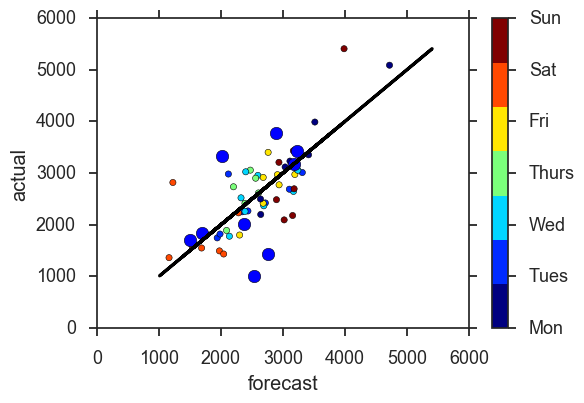

In [50]:
dates=allUSholidays.index
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweeks, cmap=plt.cm.get_cmap('jet', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

plt.scatter(y_forecasted.loc[dates], y_truth.loc[dates], c='b',s=80)


In [60]:
(y_truth-y_forecasted).sort_values(ascending=True).head()

0
2016-11-24   -1530.416784
2016-12-25   -1338.429911
2016-12-18    -977.316883
2016-11-20    -926.147794
2016-12-10    -610.191417
dtype: float64

In [61]:
(y_truth-y_forecasted).sort_values(ascending=True).tail()

0
2016-11-01     861.575685
2016-12-27     890.566562
2016-12-26    1321.979483
2016-11-27    1420.744705
2016-11-26    1592.709623
dtype: float64

761.82393760358764

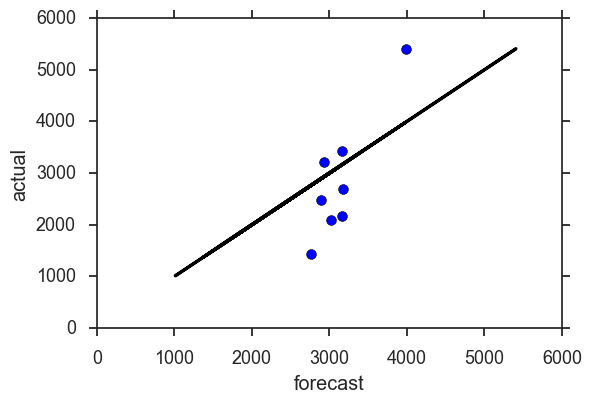

In [27]:
dazed=np.where(dayofweeks==6)
dates=allholidays.index
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
plt.scatter(y_forecasted.iloc[dazed], y_truth.iloc[dazed], c='b',s=50)
metrics.mean_absolute_error(y_truth.iloc[dazed], y_forecasted.iloc[dazed])

In [32]:
pred_dy = results.get_prediction(start='2016-12-01', dynamic=forecast_start)
pred_dy_ci = pred_dy.conf_int()

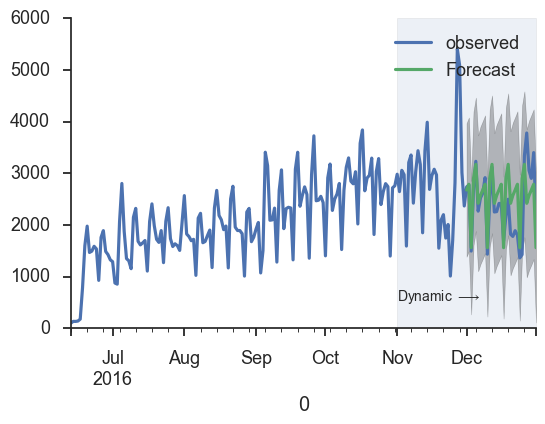

In [33]:
ax = new['counts'].plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(forecast_start), new.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp(forecast_start), 550))

plt.legend()
sns.despine()